In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 24})

import numpy as np
import glob
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from rdkit.Chem import CanonSmiles
from tqdm.auto import tqdm
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog("rdApp.error")
tqdm.pandas()

In [3]:
data = pd.read_csv("220629_dupl_rmvd.csv")
data = data[~data.No.isin([48, 199, 1155, 517, 518, 931])]

In [4]:
data = data[data["Mole/Weight/Volume Fraction"] == "mole"]

In [5]:
blends = data[
    [
        "No",
        "Mole/Weight/Volume Fraction",
        "CN",
        "DCN or ICN",
        "Method",
        "Device",
        "Comments",
        "Reference",
    ]
]

blends = blends.set_index("No")

In [6]:
blends["Mole/Weight/Volume Fraction"].value_counts()

mole    1222
Name: Mole/Weight/Volume Fraction, dtype: int64

In [7]:
smiles = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("smi_mol")],
    value_name="SMILES",
)
m_conc = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("x_mol")],
    value_name="mol_pct",
)


def try_canon_smiles(x):
    try:
        return CanonSmiles(x)
    except Exception:
        return None


smiles["SMILES"] = smiles.SMILES.apply(try_canon_smiles)
smiles["mol_pct"] = m_conc["mol_pct"]
fuel_comp = smiles.drop("variable", axis=1)

In [8]:
fuel_comp = (
    fuel_comp.dropna()
    .sort_values(["No", "mol_pct"], ascending=[True, False])
    .reset_index(drop=True)
)

# Drop a few more problematic mixtures
mol_closure = fuel_comp.groupby("No").sum().mol_pct
fuel_comp = fuel_comp[~fuel_comp.No.isin(mol_closure[mol_closure < 0.99].index)]

assert np.allclose(fuel_comp.groupby("No").sum(), 1.0, atol=0.01)
fuel_comp.head()

,No,SMILES,mol_pct
0,4,CCCCCCCCCC,0.796
1,4,Cc1ccccc1,0.204
2,5,CCCCCCCCCC,0.592
3,5,Cc1ccccc1,0.408
4,6,Cc1ccccc1,0.804


In [9]:
fuel_comp.SMILES.isna().any()

False

In [10]:
len(fuel_comp.SMILES.unique())

428

In [11]:
X = fuel_comp.pivot(columns="SMILES", index="No", values="mol_pct").fillna(0.0)
print(X.shape)
print(tf.convert_to_tensor(X).shape)
blends = blends.reindex(X.index)
y = blends.CN

(1205, 428)
(1205, 428)


2023-04-20 14:12:50.011650: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import sklearn
from sklearn.linear_model import LinearRegression

In [13]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [14]:
y.min()

0.0

Text(3, 110, 'Linear regression \nMAE: 1.86')

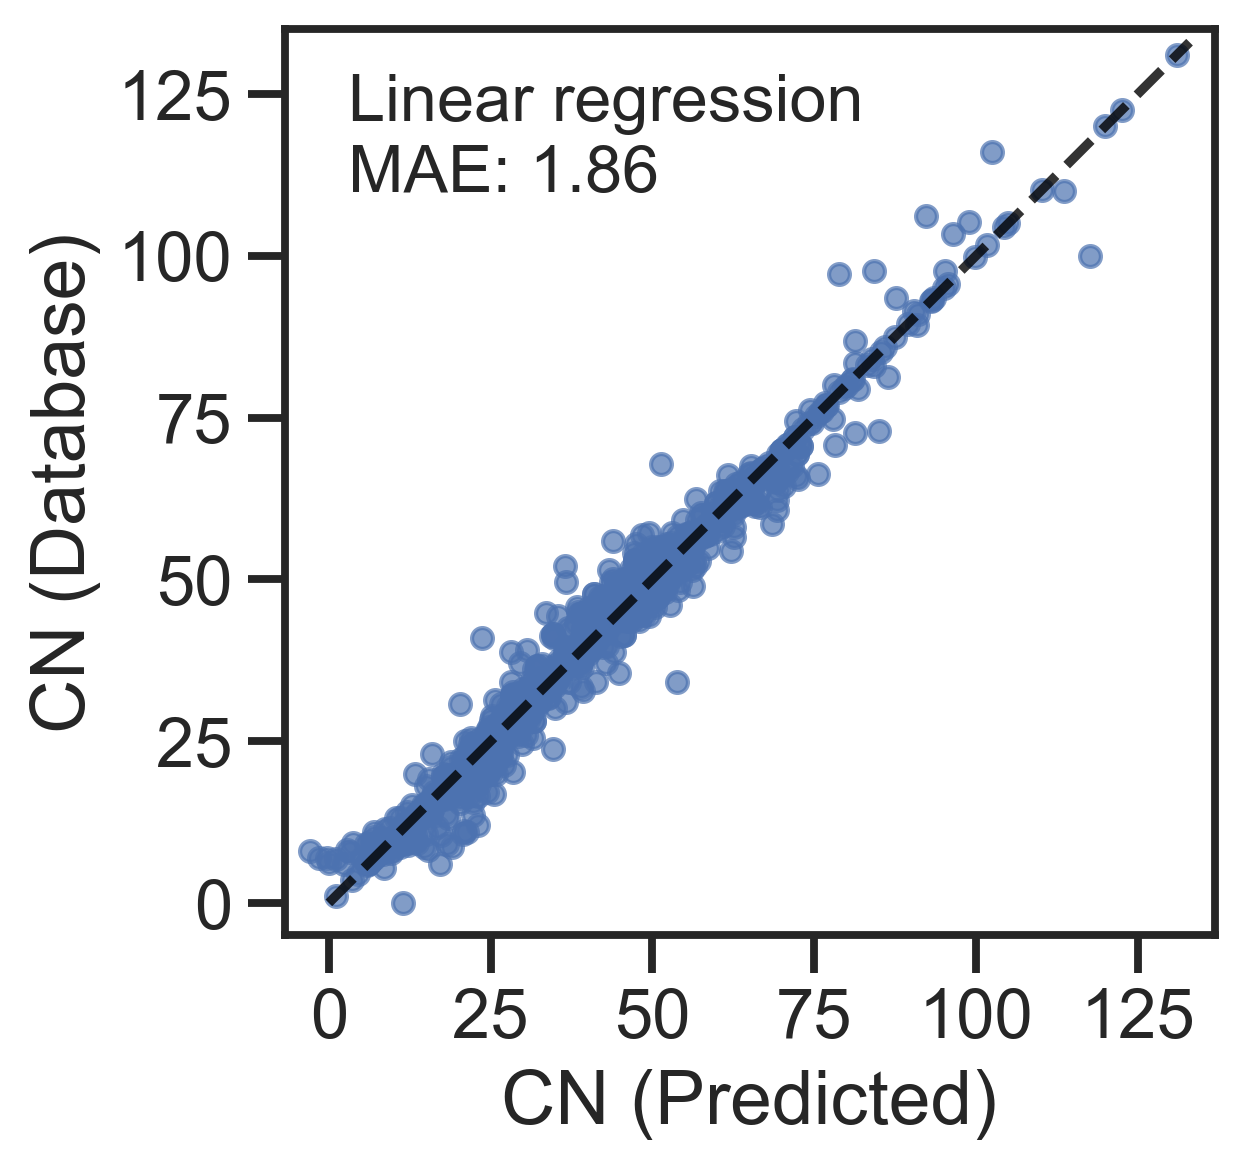

In [15]:
plt.figure(figsize=(4, 4))
plt.axis('equal')
plt.xlim([-5,135])
plt.ylim([-5,135])
plt.plot(reg.predict(X), y, ".", ms=10, alpha = 0.7)
plt.plot([0,133],[0,133], '--', color = 'black', alpha = 0.8)
plt.xlabel('CN (Predicted)')
plt.ylabel('CN (Database)')
plt.xticks([0,25,50,75,100,125])
plt.text( x=3, y=110, s='Linear regression \nMAE: 1.86', fontsize=16)

In [16]:
blends["reg_err"] = reg.predict(X) - y

In [17]:
sklearn.metrics.mean_absolute_error(reg.predict(X), y)

1.8621770171597531

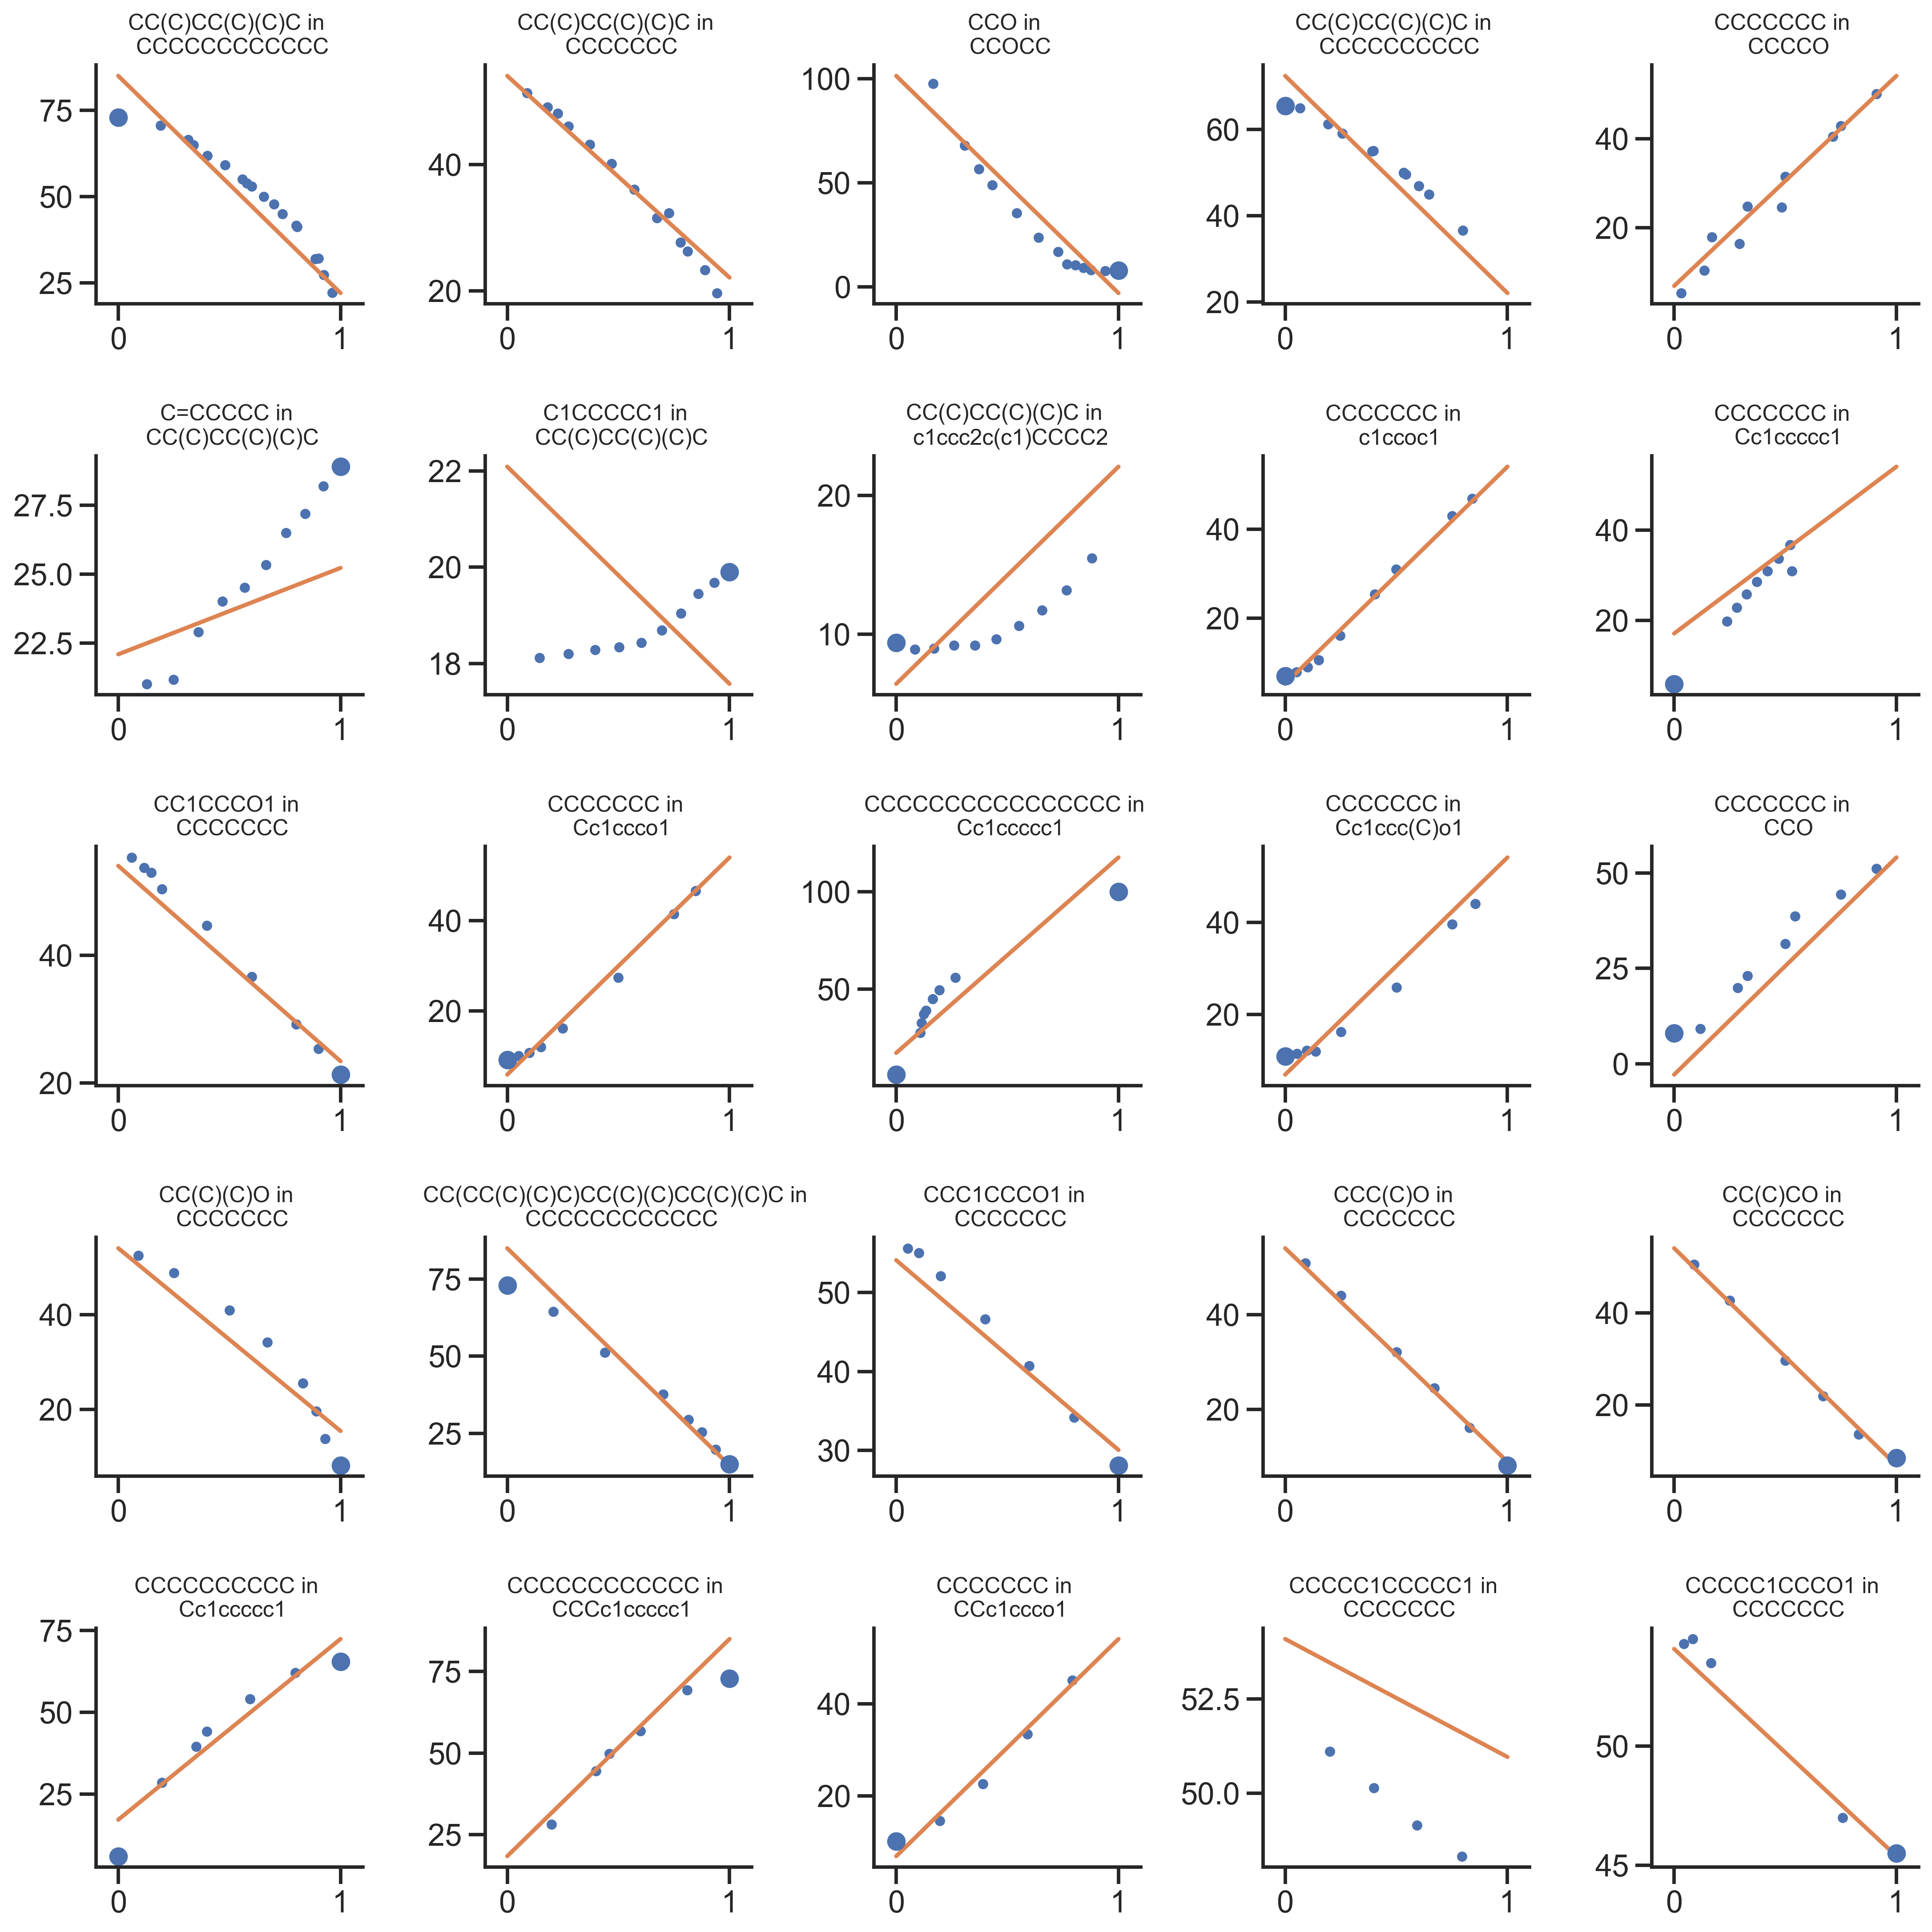

In [18]:
blends["components"] = fuel_comp.groupby("No").apply(
    lambda df: tuple(sorted(df.SMILES))
)

num_comps = fuel_comp.No.value_counts()
pure_comps = blends[blends.index.isin(num_comps[num_comps == 1].index)].copy()
pure_comps['smiles'] = pure_comps.components.apply(lambda x: x[0])
pure_comps = pure_comps.set_index('smiles')


binary_blends = blends[blends.components.apply(len) == 2].components.value_counts()


fig, axmatrix = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for smiles, ax in zip(binary_blends[binary_blends >= 3].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    
    xs = np.linspace(0, 1, num=50)
    X_reg = pd.DataFrame(np.zeros((X.shape[1], len(xs))), index=X.columns)
    X_reg[X.columns == smiles[0]] = xs
    X_reg[X.columns == smiles[1]] = 1 - xs
    
    ax.plot(xs, reg.predict(X_reg.T), '-')
    
    if smiles[0] in pure_comps.index:
        ax.plot(1, pure_comps.loc[smiles[0], 'CN'], "o", color='b')
        
    
    if smiles[1] in pure_comps.index:
        ax.plot(0, pure_comps.loc[smiles[1], 'CN'], "o", color='b')
        
    
    ax.set_xlim([-.1, 1.1])
    
sns.despine()
plt.tight_layout()

# Model for CN regression considering blend effects

$$CN = \sum_i X_i CN_i$$
$$CN_i = X W$$

Here, we assume that cetane number is determined by the linear (molar) combination of each component's blending cetane number, and that the blending cetane number is composition-dependent. We further assume that blending a component's cetane number is specified by $ x_j^T w_j $, where $x_j$ is the concentration of a given component in the blend, and $w_j$ is the blending cetane number of the current component *at infinite dilution* in component $j$. (When $i = j$, i.e., the diagonal of matrix $W$, it is the pure-component cetane number.

This assumes that blending cetane number can be described by a linear model; and for a binary blend, that the blending cetane number varies linearly between the pure-component cetane number and some infinite-dilution cetane number.


In [19]:
from cn_model import CNModel

2023-04-20 14:12:53.234017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


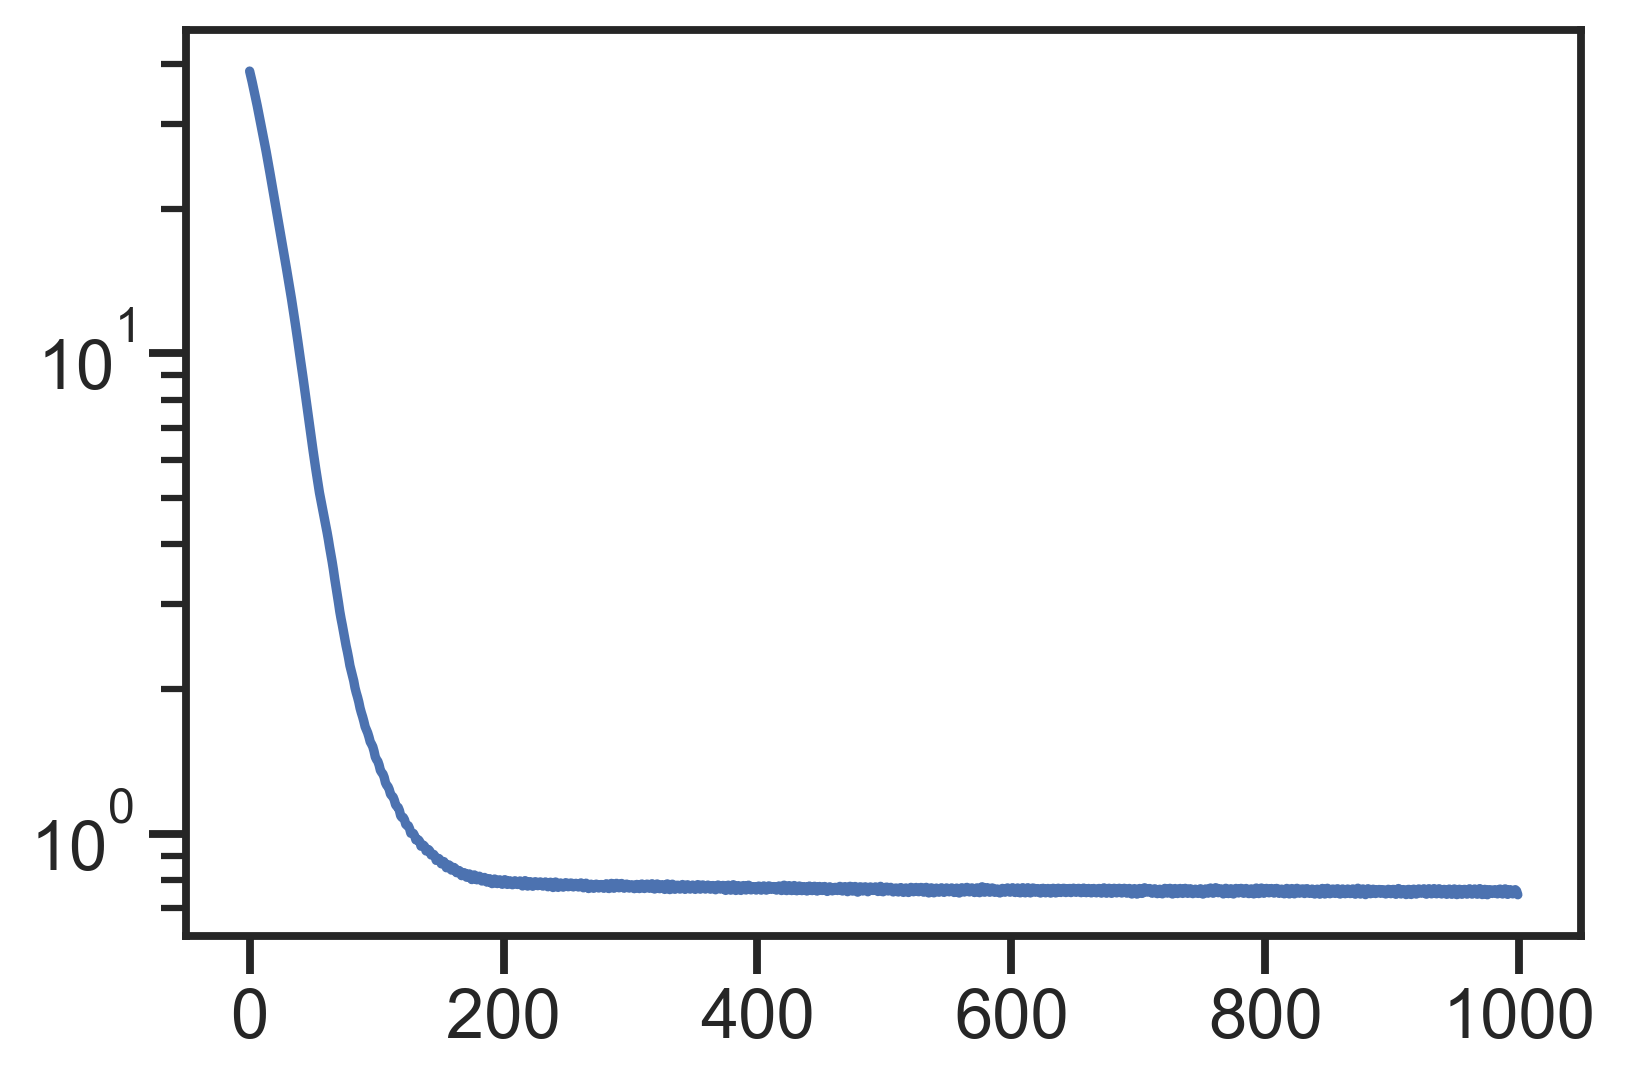

In [20]:
m = CNModel()
m.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1.))
hist = m.fit(X, y, batch_size=len(X), epochs=1000, verbose=0)
plt.semilogy(hist.history['loss'])

In [21]:
hist.history['loss'][-1]

0.7460149526596069

Text(3, 100, 'Regression with \nW matrix \nMAE: 0.74')

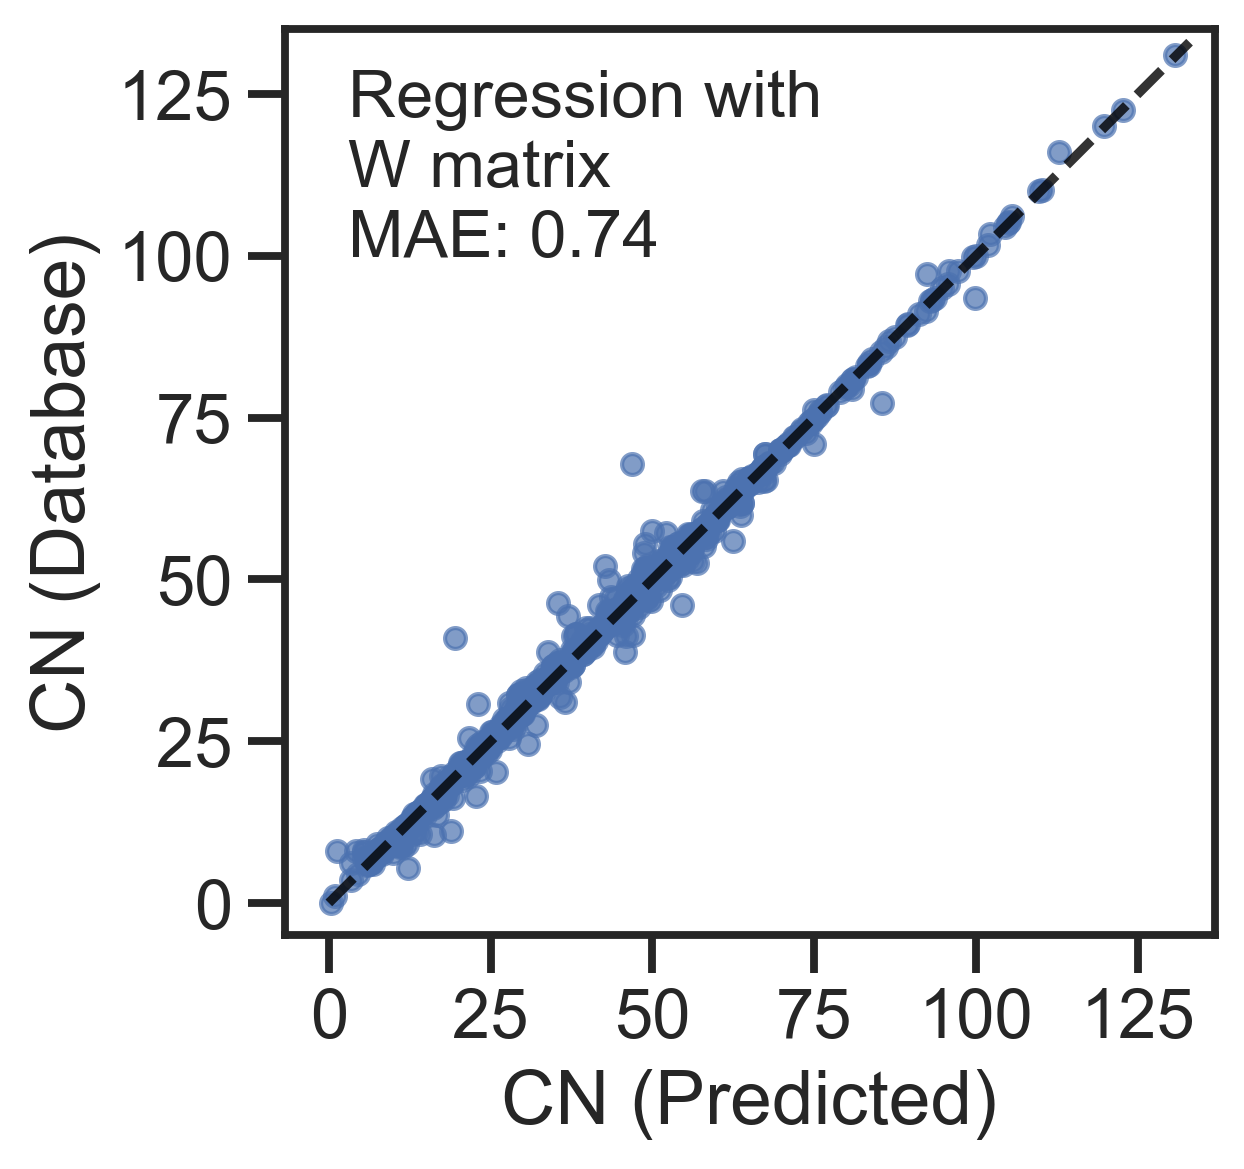

In [22]:
#plt.figure(figsize=(4, 4))
#plt.plot(m(tf.convert_to_tensor(X)), y, ".", ms=2.5)


plt.figure(figsize=(4, 4))
plt.axis('equal')
plt.xlim([-5,135])
plt.ylim([-5,135])
plt.plot(m(tf.convert_to_tensor(X)), y, ".", ms=10, alpha = 0.7)
plt.plot([0,133],[0,133], '--', color = 'black', alpha = 0.8)
plt.xlabel('CN (Predicted)')
plt.ylabel('CN (Database)')
plt.xticks([0,25,50,75,100,125])
plt.text( x=3, y=100, s='Regression with \nW matrix \nMAE: 0.74', fontsize=16)

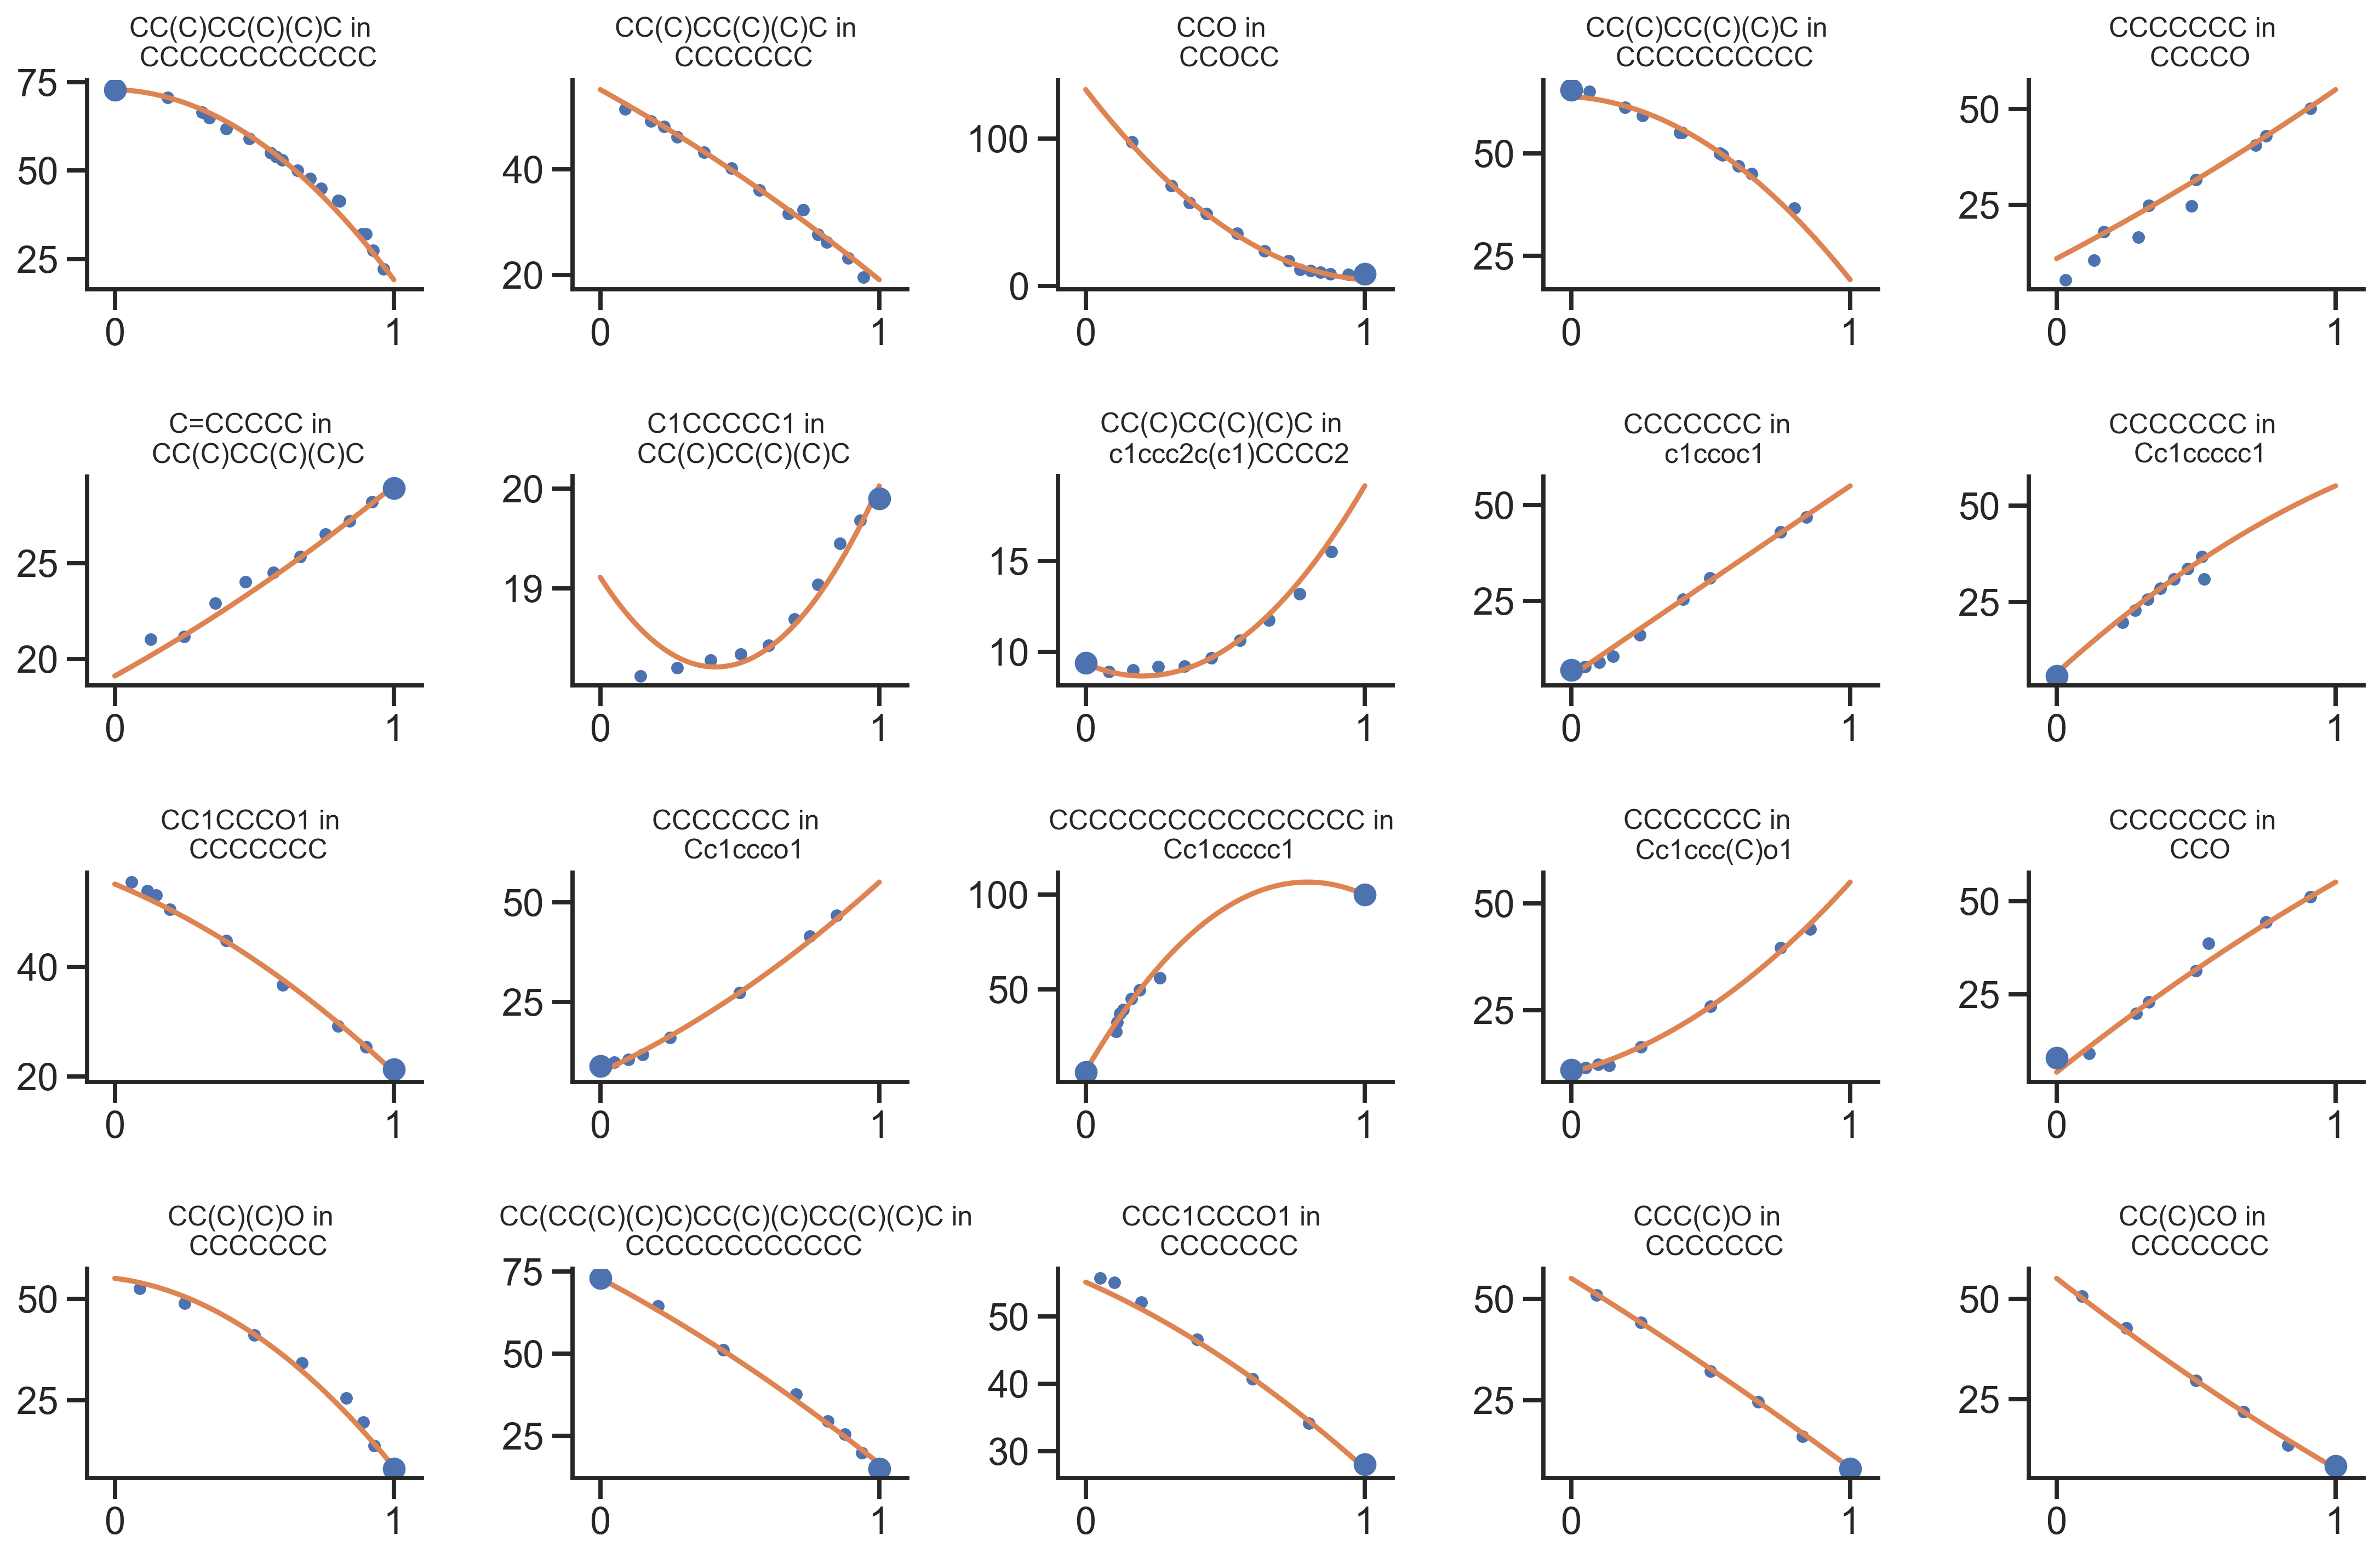

In [23]:
fig, axmatrix = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))

for smiles, ax in zip(binary_blends[binary_blends >= 5].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    
    xs = np.linspace(0, 1, num=50)
    X_reg = pd.DataFrame(np.zeros((X.shape[1], len(xs)), dtype=np.float64), index=X.columns)
    X_reg[X.columns == smiles[0]] = xs
    X_reg[X.columns == smiles[1]] = 1 - xs
    
    ax.plot(xs, m(tf.convert_to_tensor(X_reg.T)), '-')
    
    if smiles[0] in pure_comps.index:
        ax.plot(1, pure_comps.loc[smiles[0], 'CN'], "o", color='b')
        
    
    if smiles[1] in pure_comps.index:
        ax.plot(0, pure_comps.loc[smiles[1], 'CN'], "o", color='b')
        
    
    ax.set_xlim([-.1, 1.1])
    
sns.despine()
plt.tight_layout()

In [24]:
# These are the estimated pure-component cetane numbers
m1_cetane_numbers = pd.Series(np.diag(m.W.numpy()), index=X.columns)
m1_cetane_numbers

SMILES
C#CCCCCC                  22.216562
C/C(C=O)=C\c1ccccc1       19.241068
C/C=C/C=C/C(=O)OC          6.086445
C/C=C\CCCC                44.697742
C1=CCCCC1                 18.063620
                            ...    
c1ccc2c(c1)CCC2            8.442812
c1ccc2c(c1)CCCC2           9.362389
c1ccc2c(c1)ccc1ccccc12     0.516747
c1ccccc1                  14.478162
c1ccoc1                    5.409760
Length: 428, dtype: float32

## Low-rank approximations of W

For obvious reasons, requiring $n^2$ parameters for $n$ components will lead to poor validation performance for new blends. We can instead try a low-rank approximation of $W = UV$, where we approximate the $(n,n)$ matrix $W$ by two $(n,r)$ matrices.

This essentially projects components into a lower-dimensional feature space that captures their blending behavior, and we could eventually predict these features directly with a GNN or other simpler model to capture blending effects

In [25]:
from cn_model import LowRankCNModel

In [26]:
loss = []
# For some reasons, the rank 1 model MAE is fluctuating at each trial. The best MAE was 2.54
# Rank 2,3,4 models' MAEs are also changing when the training is repeated multiple times, 
# but within the 0.01-0.03 range, which does not affect the overall trend

for i in range(1, 5):
    m2 = LowRankCNModel(i)
    m2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=.01))
    hist = m2.fit(X, y, batch_size=len(X), epochs=5000, verbose=0)
    loss += [hist.history['loss'][-1]]
    print(i, "loss = ", hist.history['loss'][-1])

1 loss =  4.925370693206787
2 loss =  0.8551165461540222
3 loss =  0.7909427285194397
4 loss =  0.7535631060600281


Even with rank = 2, we do much better than the MAE=1.8 we saw in the pure linear model

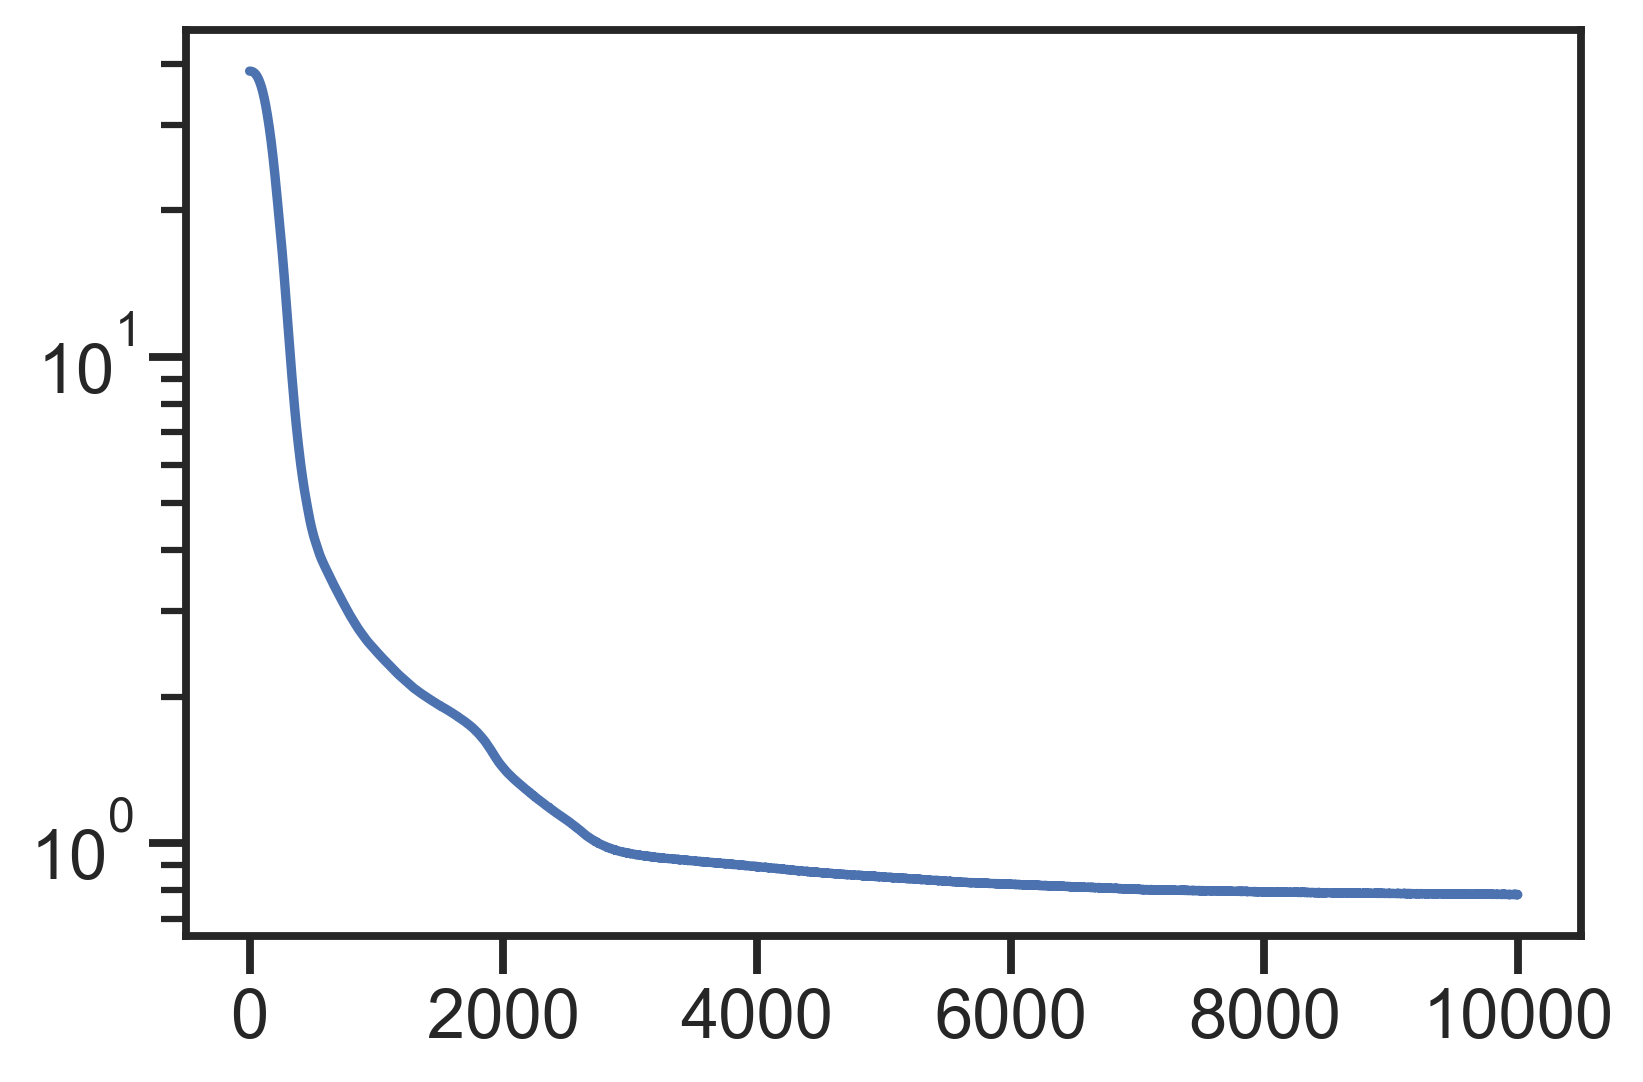

In [27]:
from cn_model import LowRankCNModel

m2 = LowRankCNModel(2)
m2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=.01))
hist = m2.fit(X, y, batch_size=len(X), epochs=10000, verbose=0)
plt.semilogy(hist.history['loss'])

In [28]:
hist.history['loss'][-1]

0.7838915586471558

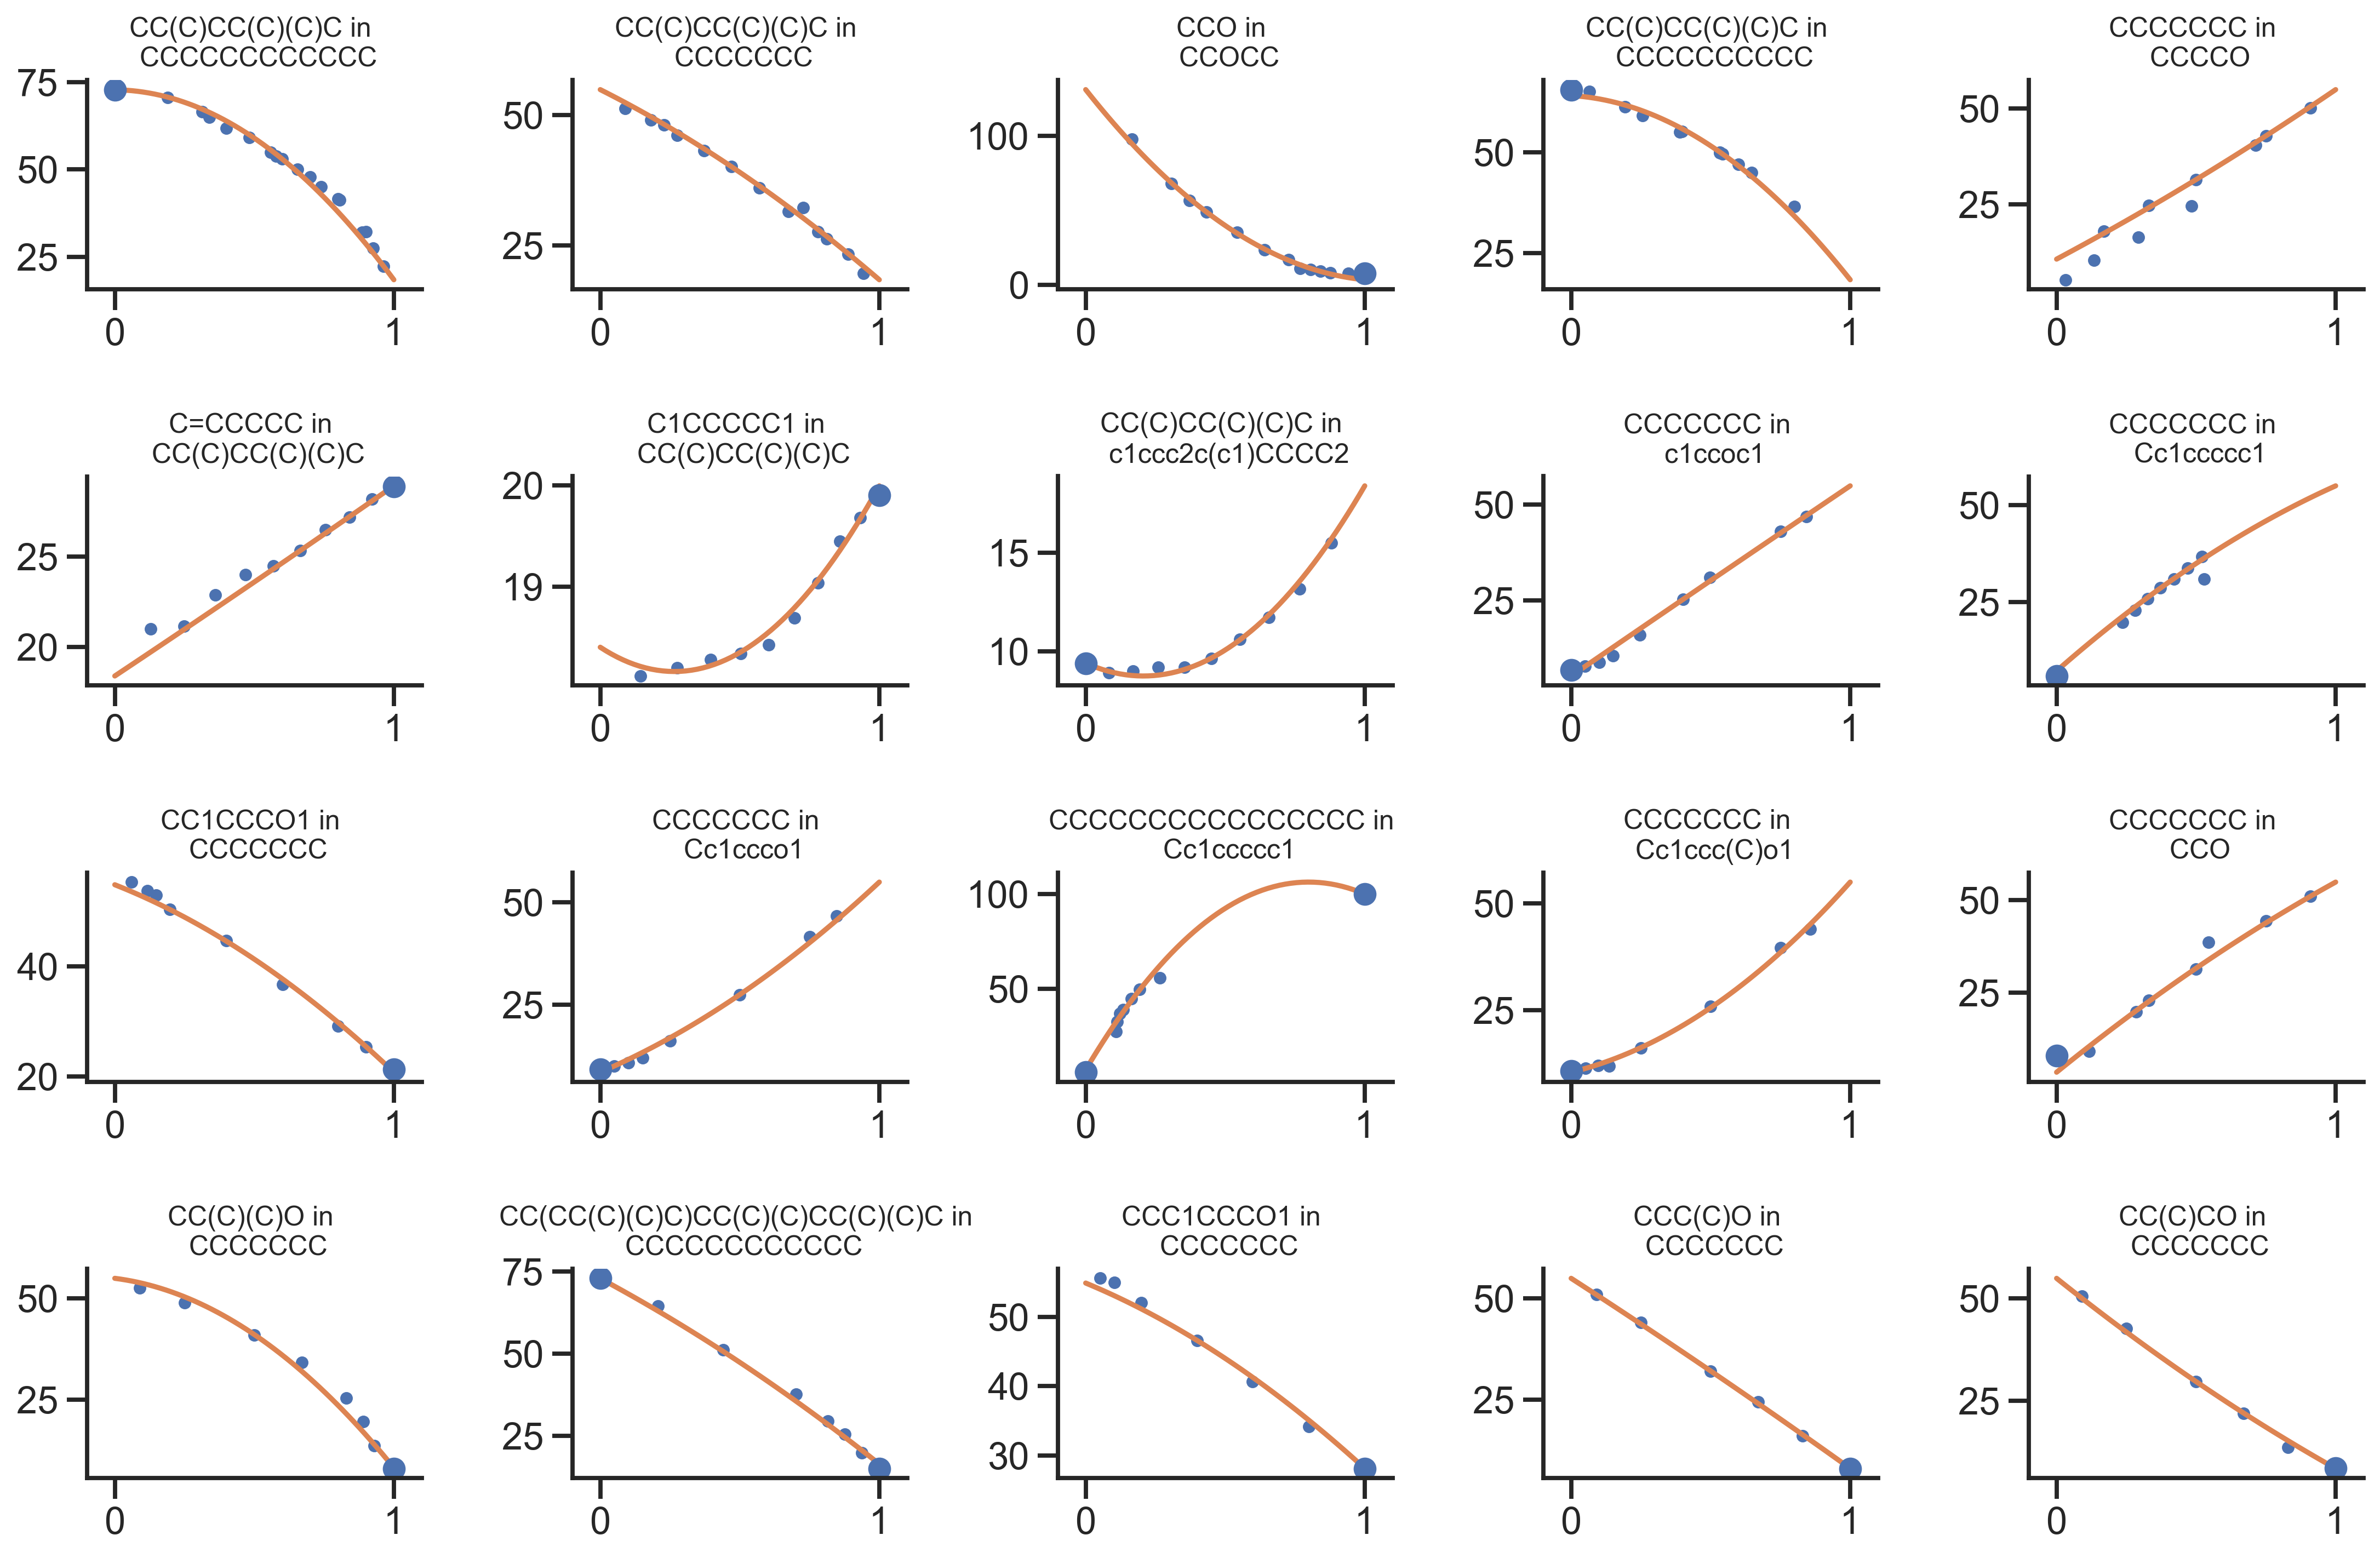

In [29]:
fig, axmatrix = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))

for smiles, ax in zip(binary_blends[binary_blends >= 5].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    
    xs = np.linspace(0, 1, num=50)
    X_reg = pd.DataFrame(np.zeros((X.shape[1], len(xs)), dtype=np.float64), index=X.columns)
    X_reg[X.columns == smiles[0]] = xs
    X_reg[X.columns == smiles[1]] = 1 - xs
    
    ax.plot(xs, m2(tf.convert_to_tensor(X_reg.T)), '-')
    
    if smiles[0] in pure_comps.index:
        ax.plot(1, pure_comps.loc[smiles[0], 'CN'], "o", color='b')
        
    
    if smiles[1] in pure_comps.index:
        ax.plot(0, pure_comps.loc[smiles[1], 'CN'], "o", color='b')
        
    
    ax.set_xlim([-.1, 1.1])
    
sns.despine()
plt.tight_layout()

([<matplotlib.axis.XTick at 0x7f88877ad090>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

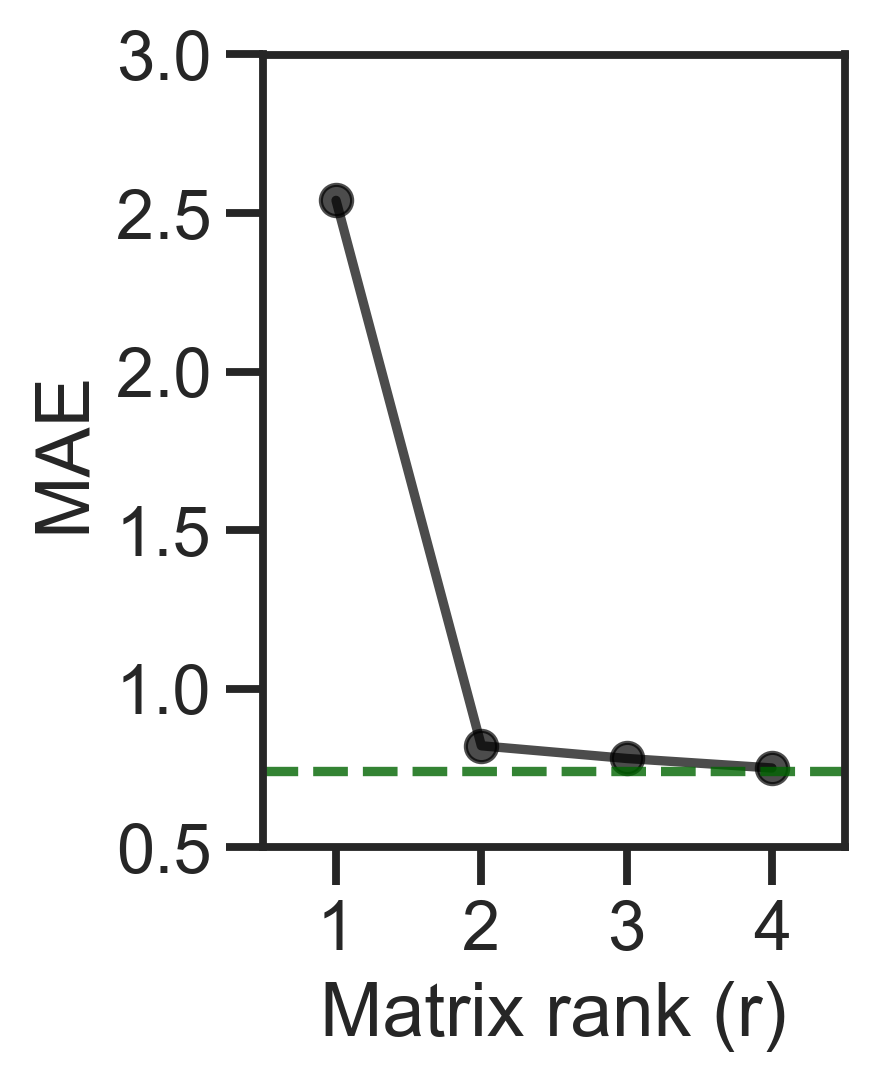

In [34]:
#plt.figure(figsize=(4, 4))
#plt.plot(m(tf.convert_to_tensor(X)), y, ".", ms=2.5)


plt.figure(figsize=(2.5,3.5))
#plt.axis('equal')
plt.xlim([0.5,4.5])
plt.ylim([0.5, 3])
plt.plot([1,2,3,4], [2.54,0.82,0.78,0.75], ".", ls='-', ms=15, alpha = 0.7, color = 'black')
plt.plot([0.5,4.5],[0.74,0.74], '--', color = 'darkgreen', alpha = 0.8)


#plt.tight_layout()
plt.xlabel('Matrix rank (r)')
plt.ylabel('MAE')

plt.xticks([1,2,3,4])
#plt.text( x=3, y=100, s='Regression with \nW matrix \nMAE: 0.74', fontsize=16)